In [2]:
import requests
from bs4 import BeautifulSoup

- 디렉토리에서 2011~2020년 크롤링

In [65]:
def get_crawling(url):
    movie_title_list=[]
    movie_genre_list=[]
    movie_director_lsit=[]
    movie_code_lsit=[]
    movie_score_list=[]

    while True:
        req = requests.get(url)
        soup = BeautifulSoup(req.text, 'html.parser')
        li_tag = soup.select("div#old_content > ul > li")
        for li in li_tag:
            # 영화제목
            movie_title = li.select_one('a').get_text() 
            movie_title_list.append(movie_title)
            movie_href = li.select_one('a')['href']
            movie_href = "https://movie.naver.com/"+movie_href
            req = requests.get(movie_href)
            soup = BeautifulSoup(req.text, 'html.parser')

            # 영화 코드
            code = movie_href.split("code=")[1]
            movie_code_lsit.append(code)

            # 영화 평점
            score = soup.select_one("div.netizen_score > div.sc_view > div.star_score > em")
            if score is None:
                movie_score_list.append(0)
            elif score is not None:
                movie_score_list.append(score.get_text())

            # 영화 감독
            director = soup.select_one("div.obj_section > div.people > ul > li > a")
            if director is None:
                movie_director_lsit.append("Null")
            elif director is not None:
                movie_director_lsit.append(director['title'])

            # 영화 장르
            span_tag = soup.select_one("dl.info_spec > dd > p > span ")
            movie_genre=""        
            if span_tag is not None:
                for a in span_tag.select('a'):
                    a = a.get_text()
                    movie_genre = movie_genre + " "+a  
                movie_genre_list.append(movie_genre)
            elif span_tag is None:
                movie_genre_list.append(0)

        req = requests.get(url)
        soup = BeautifulSoup(req.text, 'html.parser')
        td_tag = soup.select_one('td.next > a')
        if td_tag is None:
            break
        elif td_tag is not None:
            url="https://movie.naver.com"+td_tag['href']
            
    return movie_title_list, movie_genre_list, movie_director_lsit, movie_code_lsit, movie_score_list

In [66]:
movie_title_list=[]
movie_genre_list=[]
movie_director_lsit=[]
movie_code_lsit=[]
movie_score_list=[]

response = requests.get('https://movie.naver.com/movie/sdb/browsing/bmovie_open.nhn')
soup = BeautifulSoup(response.text, 'html.parser')
td_tag = soup.select("table.directory_item_other > tr > td")
a_href = []
result = []

k=0
for td in td_tag:
    if k==0:
        k+=1
        continue
    a_tag = td.select_one('a')
    a_href = "https://movie.naver.com/movie/sdb/browsing/" + a_tag['href']
    print(a_href)
    result = get_crawling(a_href)

    movie_title_list.append(result[0])
    movie_genre_list.append(result[1])
    movie_director_lsit.append(result[2])
    movie_code_lsit.append(result[3])
    movie_score_list.append(result[4])
    if k==10:
        break
    k+=1

result = {
        'movie_code_lsit' : sum(movie_code_lsit, []),
        'movie_title' : sum(movie_title_list,[]),
        'movie_genre' : sum(movie_genre_list,[]),
        'movie_director_lsit' : sum(movie_director_lsit, []),
        'movie_score_list' : sum(movie_score_list, [])
    }

https://movie.naver.com/movie/sdb/browsing/bmovie.nhn?open=2020
https://movie.naver.com/movie/sdb/browsing/bmovie.nhn?open=2019
https://movie.naver.com/movie/sdb/browsing/bmovie.nhn?open=2018
https://movie.naver.com/movie/sdb/browsing/bmovie.nhn?open=2017
https://movie.naver.com/movie/sdb/browsing/bmovie.nhn?open=2016
https://movie.naver.com/movie/sdb/browsing/bmovie.nhn?open=2015
https://movie.naver.com/movie/sdb/browsing/bmovie.nhn?open=2014
https://movie.naver.com/movie/sdb/browsing/bmovie.nhn?open=2013
https://movie.naver.com/movie/sdb/browsing/bmovie.nhn?open=2012
https://movie.naver.com/movie/sdb/browsing/bmovie.nhn?open=2011


- csv 저장

In [5]:
import pandas as pd
df=pd.DataFrame(result)
# df[df['movie_code_lsit']=='178037']
df.head()

In [ ]:
# df.to_csv('movie_final_genre.csv', index=False)

In [6]:
movies = pd.read_csv('movie_final_genre.csv')

In [7]:
movies.columns = ['movie_code', 'title', 'genre', 'director', 'score']
movies.head()

,movie_code,title,genre,director,score
0,99702,007 노 타임 투 다이 (NO TIME TO DIE),액션,캐리 후쿠나가,8.92
1,193996,108명의 여자와 섹스하는 방법 (108: REVENGE AND ADVENTURE ...,코미디 드라마,마츠오 스즈키,1.00
2,194004,16세의 사운드트랙 (Soundtrack to Sixteen),코미디 멜로/로맨스,힐러리 셰익스피어,8.00
3,187321,1917 (1917),드라마 전쟁,샘 멘데스,8.86
4,194791,1942: 언노운 배틀 (Unknown Battle),전쟁,이고르 카피로브,8.02


In [8]:
movies.shape

(10492, 5)

In [9]:
movies.dropna(axis=0, inplace=True)

In [10]:
movies.shape

(10486, 5)

In [11]:
# import re
# for i, str in enumerate(movies['title']):
#     p = re.compile('\(.*')
#     movies['title'][i] = p.sub(' ',str)

- TFIDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1,2))
tfidf_matrix = tfidf_vec.fit_transform(movies['genre'])

print(tfidf_matrix.shape) 

(10486, 365)


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

genres_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(genres_similarity)
print(genres_similarity.shape)
print("=====================================================================")
# 유사도가 높은 순으로 영화의 인덱스 값이 정렬되어 있는 array
similar_index = np.argsort(-genres_similarity)
print(similar_index) # 예) 0번째 인덱스는 870 인덱스랑 가장 유사하다
similar_index.shape

[[1.         0.         0.         ... 0.         0.29430442 0.        ]
 [0.         1.         0.20061852 ... 0.08587698 0.23840522 0.        ]
 [0.         0.20061852 1.         ... 0.         0.12458871 0.        ]
 ...
 [0.         0.08587698 0.         ... 1.         0.05333158 0.        ]
 [0.29430442 0.23840522 0.12458871 ... 0.05333158 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]
(10486, 10486)
[[    0  9964  9971 ...  3863  3866 10485]
 [ 8526  4225  6830 ...  4509  4457 10485]
 [ 4222   501   176 ...  4083  4074 10485]
 ...
 [ 1412  4314  8119 ...  4387  4411 10485]
 [10484  4142  1316 ...  4847  4886 10485]
 [10485  1454  4137 ...  3408  3401  5242]]


(10486, 10486)

- 추천

In [14]:
input_movie = input()

movie_index = movies[movies['title']==input_movie].index.values
print(movie_index)

similar_movies = similar_index[movie_index, :int(100)]
# print(similar_movies, len(similar_movies[0]))

print("============")
similar_movies_index = similar_movies.reshape(-1) # 차원 맞춰준다
# print(similar_movies_index)
# print(movies.iloc[similar_movies_index])

 앤트맨 (Ant-Man)


[5500]


In [28]:
print(similar_index[5500][:100])
similar_list = genres_similarity[5500]
similar_list = sorted(similar_list, reverse=True)[:100]
print(similar_list)
dic = {

}

[ 6303  5500  1738  4494  5485  4362  2382  6852   841  6844  6307  6306
  6305  9735  3594  3897  6304   233  4549  8385  2456  7753   519  5719
  6550   866  4252  5648  1334  7044  6874  1340  2736  9582  2002  1099
  6227  4478  2357  3812  6883  4200  5552   365  3457  6963 10240  5944
  1998  8439  2733  1825  3331 10424 10086  4250  4703  2837  6368  7364
  5100  4485  4955  9472  3273  1751 10274  6657  9112  9478 10150  3800
  7580  3874   413 10065  1677  8678  9355 10384  7647  7819  9068  4942
  6626   137  6570   719  5209   833  2159   750   300  6958  1195  1197
  7187   425  5473  6363]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7699969694746229, 0.7699969694746229, 0.7699969694746229, 0.7699969694746229, 0.7699969694746229, 0.7699969694746229, 0.7699969694746229,

In [29]:
import re
p=re.compile('\(.*')

a = movies.iloc[similar_movies_index]['title']
for i,j in zip(a, similar_list):
    i = p.sub('', i)
    dic[i] = j
dic

{'넥스트 제네레이션 패트레이버 ': 1.0,
 '앤트맨 ': 1.0,
 '매드맥스: 로드 워 ': 1.0,
 '코어 임팩트: 행성 충돌 ': 1.0,
 '안드로이드 캅 ': 1.0,
 '익스트림 터미네이터 TR': 1.0,
 '한 솔로: 스타워즈 스토리 ': 1.0,
 '슈퍼스톰 ': 1.0,
 '마피아 ': 1.0,
 '슈퍼 사이클론 스톰 ': 1.0,
 '넥스트 투모로우2 ': 1.0,
 '넥스트 제네레이션 패트레이버 4': 1.0,
 '넥스트 제네레이션 패트레이버 3 ': 1.0,
 '고질라 - 파이널 워즈 ': 1.0,
 '극장판 울트라맨 우주 몬스터 대결전 ': 1.0,
 '미국 대지진:샌 안드레스 ': 1.0,
 '넥스트 제네레이션 패트레이버 2 ': 1.0,
 '블랙아웃 : 인베이젼 어스 ': 1.0,
 '특수부대 사이보그 솔저 ': 1.0,
 '오블리비언 ': 1.0,
 '가디언즈 오브 갤럭시 VOL. 2 ': 1.0,
 '넥스트 투모로우 ': 1.0,
 '테넷 ': 1.0,
 '익스트림 터미네이터 ': 1.0,
 '마이애미 대침몰 ': 1.0,
 '몬스터 가디언즈 ': 1.0,
 '에조: 인류 최후의 전쟁 ': 1.0,
 '울트라맨 사가 ': 1.0,
 '타임 트랩 킬러 ': 1.0,
 '엣지 오브 투모로우 ': 1.0,
 '스타쉽 라이징 ': 1.0,
 '터미네이터 솔저 ': 1.0,
 '로건 ': 1.0,
 '토탈 리콜 ': 1.0,
 '아큐페이션 ': 1.0,
 '어벤져스: 엔드게임 ': 1.0,
 '극장판 가면라이더 vs 파워레인저 슈퍼히어로 대전 ': 1.0,
 '칼큘레이터 ': 1.0,
 '프로젝트 메자 ': 1.0,
 '론울브스 ': 1.0,
 '스톰 둠스데이 ': 1.0,
 '안드론: 블랙 라비린스 ': 1.0,
 '에일리언 라이징 ': 1.0,
 '엔젤스 폴른 ': 1.0,
 '행성탈출: 반란의 서막 ': 1.0,
 '아틀란틱 림 ': 1.0,
 '월드 인베이젼 ': 1.0,
 '판타스틱 4 ': 1.0,
 '아인 ': 1.0

- 시각화

In [215]:
# !pip install wordcloud

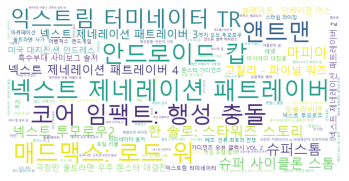

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

my_wc = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', background_color='white', width=800, height=400)
plt.imshow(my_wc.generate_from_frequencies(dic))
plt.axis('off') # x, y 축 숫자 제거
plt.show()